In [1]:
import torch
import torch.nn.functional as F
import torch.utils.data
from transformers import GPT2Tokenizer
from PIL import Image
from utils import proc_ques
from models.gpt import GPT2LMHeadModel
import clip_x.clip as clip
from transformers import top_k_top_p_filtering
from PIL import Image
import numpy as np
import cv2, math
import matplotlib.pyplot as plt
from captum.attr import visualization
import json
from models.gpt import NLX_GPT
from torchvision.transforms import GaussianBlur

/home/pr03/anaconda3/envs/t5/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
caption_save_path = '/media/storage/coco/caption_data' 
annFileExp = '../self_training/cococaption/annotations/vqaX_test_annot_exp.json'
annFileFull = '../self_training/cococaption/annotations/vqaX_test_annot_full.json'
nle_data_test_path = '/media/storage/coco/VQA-X/annotated/vqaX_test.json'
nle_data_val_path = '/media/storage/coco/VQA-X/annotated/vqaX_val.json'
nle_data_train_path = '/media/storage/coco/VQA-X/annotated/vqaX_train.json'

In [3]:
def load_checkpoint(ckpt_path, epoch):
    
    model_name = 'nle_model_{}'.format(str(epoch))
    tokenizer_name = 'nle_gpt2_tokenizer_0'
    filename = 'ckpt_stats_' + str(epoch) + '.tar'
    
    tokenizer = GPT2Tokenizer.from_pretrained(ckpt_path + tokenizer_name)        # load tokenizer
    model = GPT2LMHeadModel.from_pretrained(ckpt_path + model_name).to(device)   # load model with config

    return tokenizer, model
def change_requires_grad(model, req_grad):
    for p in model.parameters():
        p.requires_grad = req_grad
def get_elements(question_id):
    sample = data[question_id]
    img_name = sample['image_name']
    text_a = proc_ques(sample['question'])    # question

    # tokenization process
    q_segment_id, a_segment_id, e_segment_id = tokenizer.convert_tokens_to_ids(['<question>', '<answer>', '<explanation>'])
    tokens = tokenizer.tokenize(text_a)
    segment_ids = [q_segment_id] * len(tokens)
    answer = [tokenizer.bos_token] + tokenizer.tokenize(" the answer is")
    answer_len = len(answer)
    tokens += answer 

    segment_ids += [a_segment_id] * answer_len

    input_ids = tokenizer.convert_tokens_to_ids(tokens)
    input_ids = torch.tensor(input_ids, dtype=torch.long)
    segment_ids = torch.tensor(segment_ids, dtype=torch.long)
    
    folder = './media/storage/coco/image/train2014/' if 'train' in img_name else '/media/storage/coco/image/val2014/'   # test and val are both in val2014
    img_path = folder + img_name
    img = Image.open(img_path)
    #.convert('RGB')
    img = img_transform(img)
    qid = torch.LongTensor([int(question_id)])

    return ((img, qid, input_ids, segment_ids, img_path), (sample['question'], sample['answers'],sample["explanation"]))


In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

tokenizer, model = load_checkpoint(ckpt_path="ckpts/VQAX_p/",epoch = 11)
clip._MODELS = {
    "ViT-B/32": "https://openaipublic.azureedge.net/clip/models/40d365715913c9da98579312b702a82c18be219cc2a73407c4526f58eba950af/ViT-B-32.pt",
    "ViT-B/16": "https://openaipublic.azureedge.net/clip/models/5806e77cd80f8b59890b7e101eabd078d9fb84e6937f9e85e4ecb61988df416f/ViT-B-16.pt",
    "ViT-L/14": "https://openaipublic.azureedge.net/clip/models/b8cca3fd41ae0c99ba7e8951adf17d267cdb84cd88be6f7c2e0eca1737a03836/ViT-L-14.pt"
}

clip_model, preprocess = clip.load("ViT-B/16", jit=False)
print("Image resolution:", clip_model.visual.input_resolution)
image_encoder = clip_model
# change_requires_grad(image_encoder, False)
img_transform = preprocess

img_size = 224
max_seq_len = 60
do_sample = False
top_k =  0
top_p =  0.9
temperature = 1
start_layer = 11
load_from_epoch = 11
ckpt_path = '../self_training/ckpts/VQAX_p/'

SPECIAL_TOKENS = ['<|endoftext|>', '<pad>', '<question>', '<answer>', '<explanation>']
special_tokens_ids = tokenizer.convert_tokens_to_ids(SPECIAL_TOKENS)
because_token_id = tokenizer.convert_tokens_to_ids('Ġbecause')


nlx_gpt = NLX_GPT(visual_backbone=image_encoder, lm_backbone=model).to(device)

data = json.load(open(nle_data_test_path, "r"))
ids_list = list(data.keys())

Image resolution: 224


/home/pr03/anaconda3/envs/t5/lib/python3.7/site-packages/torchvision/transforms/transforms.py:333: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "


In [5]:
q_id = ids_list[10]
batch, sample = get_elements(q_id)
img_path = batch[-1]
batch = tuple(input_tensor.unsqueeze(0).to(device) for input_tensor in batch[:-1])
img, img_id, input_ids, segment_ids = batch
batch_size = img.shape[0]
img_relevance_maps = []
current_output = []
current_logits = []
always_exp = False

///////////// DETR /////////////////////

In [6]:
import torchvision

class FrozenBatchNorm2d(torch.nn.Module):
    """
    BatchNorm2d where the batch statistics and the affine parameters are fixed.

    Copy-paste from torchvision.misc.ops with added eps before rqsrt,
    without which any other models than torchvision.models.resnet[18,34,50,101]
    produce nans.
    """

    def __init__(self, n):
        super(FrozenBatchNorm2d, self).__init__()
        self.register_buffer("weight", torch.ones(n))
        self.register_buffer("bias", torch.zeros(n))
        self.register_buffer("running_mean", torch.zeros(n))
        self.register_buffer("running_var", torch.ones(n))

    def _load_from_state_dict(self, state_dict, prefix, local_metadata, strict,
                              missing_keys, unexpected_keys, error_msgs):
        num_batches_tracked_key = prefix + 'num_batches_tracked'
        if num_batches_tracked_key in state_dict:
            del state_dict[num_batches_tracked_key]

        super(FrozenBatchNorm2d, self)._load_from_state_dict(
            state_dict, prefix, local_metadata, strict,
            missing_keys, unexpected_keys, error_msgs)

    def forward(self, x):
        # move reshapes to the beginning
        # to make it fuser-friendly
        w = self.weight.reshape(1, -1, 1, 1)
        b = self.bias.reshape(1, -1, 1, 1)
        rv = self.running_var.reshape(1, -1, 1, 1)
        rm = self.running_mean.reshape(1, -1, 1, 1)
        eps = 1e-5
        scale = w * (rv + eps).rsqrt()
        bias = b - rm * scale
        return x * scale + bias
backbone = getattr(torchvision.models, 'resnet50')(
    replace_stride_with_dilation=[False, False, False],
    pretrained=True, norm_layer=FrozenBatchNorm2d
    ).to(device)

In [7]:
img_data = img.to(device)

In [8]:
outputs = backbone(img_data)
outputs.shape

torch.Size([1, 1000])

In [9]:
conv_features = []
backbone.register_forward_hook(lambda self, input, output: conv_features.append(output))

/////////////////////////////////////////////////////////

In [6]:
def avg_heads(cam, grad):
    cam = cam.reshape(-1, cam.shape[-2], cam.shape[-1])
    grad = grad.reshape(-1, grad.shape[-2], grad.shape[-1])
    cam = grad * cam
    cam = cam.clamp(min=0).mean(dim=0)
    return cam
def handle_self_attention_image(encoder_blocks, R_i_i, one_hot):
    for blk in encoder_blocks:
        grad = torch.autograd.grad(one_hot, [blk.attn_probs], retain_graph=True)[0].detach()
        cam = blk.attn_probs.detach()
        cam = avg_heads(cam, grad)
        R_i_i += torch.matmul(cam, R_i_i)
    return R_i_i
def apply_self_attention_rules(R_ss, R_sq, cam_ss):
    R_sq_addition = torch.matmul(cam_ss, R_sq)
    R_ss_addition = torch.matmul(cam_ss, R_ss)
    return R_ss_addition, R_sq_addition
def handle_co_attn_self_query(block, R_q_q, R_q_i, one_hot ):
    grad = torch.autograd.grad(one_hot, [block.attn.get_attn()], retain_graph=True)[0].detach()
    cam = block.attn.get_attn().detach()
    cam = avg_heads(cam, grad)
    R_q_q_add, R_q_i_add = apply_self_attention_rules(R_q_q, R_q_i, cam)
    R_q_q += R_q_q_add
    R_q_i += R_q_i_add
    return R_q_q, R_q_i
def handle_residual(orig_self_attention):
    self_attention = orig_self_attention.clone()
    diag_idx = range(self_attention.shape[-1])
    self_attention -= torch.eye(self_attention.shape[-1]).to(self_attention.device)
    assert self_attention[diag_idx, diag_idx].min() >= 0
    self_attention = self_attention / self_attention.sum(dim=-1, keepdim=True)
    self_attention += torch.eye(self_attention.shape[-1]).to(self_attention.device)
    return self_attention
def apply_mm_attention_rules(R_ss, R_qq, cam_sq, apply_normalization=True, apply_self_in_rule_10=True):
    R_ss_normalized = R_ss
    R_qq_normalized = R_qq
    if apply_normalization:
        R_ss_normalized = handle_residual(R_ss)
        R_qq_normalized = handle_residual(R_qq)
    R_sq_addition = torch.matmul(R_ss_normalized.t(), torch.matmul(cam_sq, R_qq_normalized))
    if not apply_self_in_rule_10:
        R_sq_addition = cam_sq
    R_sq_addition[torch.isnan(R_sq_addition)] = 0
    
    return R_sq_addition
def handle_co_attn_query(block, R_q_i, R_q_q, R_i_i, one_hot):
    grad_q_i = torch.autograd.grad(one_hot, [block.crossattention.get_attn()], retain_graph=True)[0].detach()
    cam_q_i = block.crossattention.get_attn().detach()
    cam_q_i = avg_heads(cam_q_i, grad_q_i)
    R_q_i += apply_mm_attention_rules(R_q_q, R_i_i[1:,1:], cam_q_i,apply_normalization=True,apply_self_in_rule_10=True)
    return R_q_i
def show_image_relevance(image_relevance, image, orig_image):
    # create heatmap from mask on image
    def show_cam_on_image(img, mask):
        heatmap = cv2.applyColorMap(np.uint8(255 * mask), cv2.COLORMAP_JET)
        heatmap = np.float32(heatmap) / 255
        cam = heatmap + np.float32(img)
        cam = cam / np.max(cam)
        return cam
    transform = GaussianBlur(kernel_size=(7, 13), sigma=(0.1, 0.2))
    # plt.axis('off')
    # f, axarr = plt.subplots(1,2)
    # axarr[0].imshow(orig_image)

    fig, axs = plt.subplots(1, 2)
    axs[0].imshow(orig_image);
    axs[0].axis('off');
    
    feat_hw = int(math.sqrt(image_relevance.shape[-1]))
    image_relevance = image_relevance.reshape(1, 1, feat_hw, feat_hw)
    image_relevance = torch.nn.functional.interpolate(image_relevance, size=224, mode='bilinear')
    image_relevance = transform(image_relevance)
    image_relevance = image_relevance.reshape(224, 224).cuda().data.cpu().numpy()
    image_relevance = (image_relevance - image_relevance.min()) / (image_relevance.max() - image_relevance.min())
    image = image[0].permute(1, 2, 0).data.cpu().numpy()
    image = (image - image.min()) / (image.max() - image.min())
    vis = show_cam_on_image(image, image_relevance)
    vis = np.uint8(255 * vis)
    vis = cv2.cvtColor(np.array(vis), cv2.COLOR_RGB2BGR)
    # axar[1].imshow(vis)
    axs[1].imshow(vis);
    axs[1].axis('off');
def show_heatmap_on_text(idx, text_encoding, R_text):
    text_scores = R_text / R_text.sum()
    text_scores = text_scores.flatten()
    text_tokens=text_encoding[idx]
    text_tokens_decoded=[tokenizer.decode([text_tokens])]
    vis_data_records = [visualization.VisualizationDataRecord(text_scores,0,0,0,0,0,text_tokens_decoded,1)]
    visualization.visualize_text(vis_data_records)

In [9]:
print(tokenizer.decode(input_ids[0]))
input_ids

what kind of vehicle is shown<|endoftext|> the answer is


tensor([[10919,  1611,   286,  4038,   318,  3402, 50256,   262,  3280,   318]],
       device='cuda:0')

In [13]:
relevance_maps = []
answer_relevance_maps = []
answer_tkn_relevance_maps = []
explanation_relevance_maps = []
current_output = []
current_logits = []
always_exp = False
for step in range(max_seq_len+1):
    logits = nlx_gpt(image=img, input_ids=input_ids, segment_ids=segment_ids)
    filtered_logits = top_k_top_p_filtering(logits, top_k=top_k, top_p=top_p)
    probs = F.softmax(filtered_logits, dim=-1)
    prev = torch.multinomial(probs, dim=-1) if do_sample else torch.argmax(filtered_logits, dim=-1).unsqueeze(-1)
    one_hot = F.one_hot(prev, num_classes=logits.shape[-1]).type(torch.float32)
    one_hot = one_hot.requires_grad_(True).cuda()
    one_hot = torch.sum(one_hot.cuda()*logits, dim=-1)
    # nlx_gpt.zero_grad()
    
    encoder_blocks = list(dict(nlx_gpt.visual_encoder.visual.transformer.resblocks.named_children()).values())
    decoder_blocks = nlx_gpt.lm.transformer.h

    image_bboxes = encoder_blocks[0].attn_probs.shape[-1]
    queries_num = decoder_blocks[0].attn.get_attn().shape[-1]

    # image self attention matrix
    R_i_i = torch.eye(image_bboxes, image_bboxes).to(encoder_blocks[0].attn_probs.device)
    # queries self attention matrix
    R_q_q = torch.eye(queries_num, queries_num).to(encoder_blocks[0].attn_probs.device)
    # impact of image boxes on queries
    R_q_i = torch.zeros(queries_num, image_bboxes-1).to(encoder_blocks[0].attn_probs.device)

    R_i_i = handle_self_attention_image(encoder_blocks, R_i_i, one_hot )

    for blk in decoder_blocks:
            # decoder self attention
        R_q_q, R_q_i = handle_co_attn_self_query(blk, R_q_q, R_q_i, one_hot)

        # encoder decoder attention
        R_q_i = handle_co_attn_query(blk, R_q_i, R_q_q, R_i_i, one_hot)
    aggregated = R_q_i.unsqueeze_(0)
    # take [CLS] row
    image_relevance = aggregated[:,-1,:].unsqueeze_(0)
    # image relevance
    if prev.item() in special_tokens_ids:
        break
    # take care of when to start the <explanation> token
    if not always_exp:
        if prev.item()!=because_token_id:
            new_segment = special_tokens_ids[-2] # answer segment
            answer_relevance_maps.append(image_relevance)
        else:
            new_segment = special_tokens_ids[-1] # explanation segment
            always_exp = True
    else:
        new_segment = special_tokens_ids[-1] # explanation segment
        explanation_relevance_maps.append(image_relevance)
    new_segment = torch.LongTensor([new_segment]).to(device)
    current_output.append(prev)
    current_logits.append(logits.unsqueeze(1))
    input_ids = torch.cat((input_ids, prev), dim=1)
    segment_ids = torch.cat((segment_ids, new_segment.unsqueeze(0).expand(segment_ids.shape[0],-1)), dim=1)

current_output = torch.cat(current_output, dim=1)
current_logits = torch.cat(current_logits, dim=1)
current_output = current_output.detach().cpu().tolist()
# current_output = tokenizer.decode(current_output[0], clean_up_tokenization_space=True)

In [14]:
output_txt = tokenizer.decode(current_output[0], clean_up_tokenization_space=True)
output_txt

' bus because it is large and has many seats'

In [15]:
tokenizer.decode(input_ids[0])

'what kind of vehicle is shown<|endoftext|> the answer is bus because it is large and has many seats'

In [16]:
current_output[0].remove(780)

In [17]:
mean_answer_relevance_maps = torch.cat(answer_relevance_maps, dim =1)
mean_answer_relevance_maps = torch.mean(mean_answer_relevance_maps, dim = 1)
mean_explanation_relevance_maps = torch.cat(explanation_relevance_maps, dim =1)
mean_explanation_relevance_maps = torch.mean(mean_explanation_relevance_maps, dim = 1)

True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
0,0 (0.00),0,0.00,bus


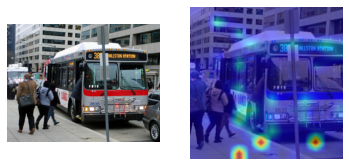

True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
0,0 (0.00),0,0.00,it


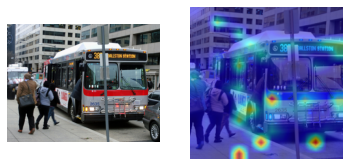

True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
0,0 (0.00),0,0.00,is


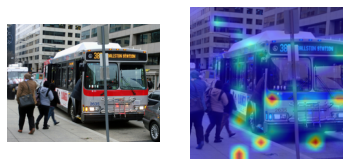

True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
0,0 (0.00),0,0.00,large


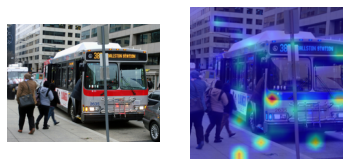

True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
0,0 (0.00),0,0.00,and


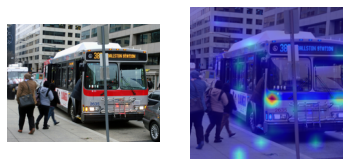

True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
0,0 (0.00),0,0.00,has


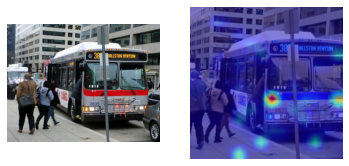

True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
0,0 (0.00),0,0.00,many


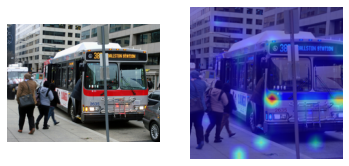

True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
0,0 (0.00),0,0.00,seats


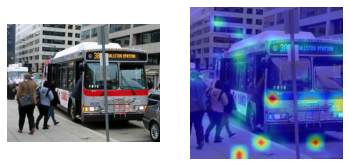

In [18]:
pil_image = Image.open(img_path)
for idx, txt_map in enumerate(answer_relevance_maps + explanation_relevance_maps):
    show_heatmap_on_text(idx,current_output[0], txt_map)
    show_image_relevance(txt_map, img, pil_image)
    plt.show()